# Graded exercise: Modeling neurons

Blue Brain Project / EPFL ©2005-2017. This notebook is under a [LGPLv3](https://raw.githubusercontent.com/BlueBrain/MOOC-neurons-and-synapses-2017/master/LICENSE.txt) license.

## Problem description

In this exercise you should find the relationship between the diameter of a dendrite and the attenuation of synaptic EPSPs.

An EPSP is the potential difference caused by the activation of a synapse. Below you find code that shows you the synaptic attenuation. By putting the synapse further and further from the soma, EPSPs become smaller and smaller, i.e. they are attenuated by traveling through the dendrite.

Below you find the code to calculate the [exponential decay constant](https://en.wikipedia.org/wiki/Exponential_decay) of the EPSP amplitude.

Now try to find the relationship between the (uniform) diameter of the dendrite, and the synaptic attenuation. For this vary the diameter (use 'for' loop) between .1 -> 10 micron.

You can use:
diam_range = numpy.linspace(.1, 10.0, 20)

Save the exponential decay constant for each diameter, and plot the log of the exponential decay constant (on Y-axis) against the log of diam_range (on X-axis).

This should form a linear relationship. Use numpy.polyfit to fit a line to this relationship.

a, b = numpy.polyfit(x, y, 1)

and send us the slope parameter 'a' of the fit.

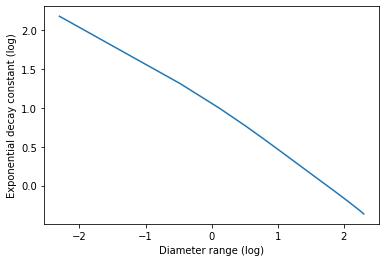

[8.833480690308058, 3.713659346053643, 2.683202923598901, 2.1582001169945695, 1.8289444141710909, 1.600869560455349, 1.4332725806020847, 1.3043959143376156, 1.2017720860219827, 1.1177858186241807, 1.0478375306270584, 0.9881462301244176, 0.9364178836506719, 0.890475289746294, 0.8498647964678769, 0.8131949458185763, 0.7796280298939943, 0.7487608487414618, 0.7209016601345197, 0.6938030111853708]
Slope parameter "a": -0.568625


In [25]:
# SOLUTION

import neuron
import numpy
import matplotlib.pyplot as plt

neuron.h.load_file("stdrun.hoc");
neuron.h.stdinit();

# Define soma
soma = neuron.h.Section(name='soma')
soma.L = 40
soma.diam = 40
soma.insert('hh');
soma.gl_hh = 5e-4 # Leak conductance, S/cm^2
soma.el_hh = -65 # Reversal potential leak current, mV
soma.gkbar_hh = 0.0 # in S/cm^2
soma.gnabar_hh = 0.0

# Define dendrite
dend = neuron.h.Section(name='dend')
dend.connect(soma, 0)
dend.insert('hh')
dend.el_hh = -65 # Reversal potential leak current, mV
dend.gl_hh = 5e-4 # Leak conductance, S/cm^2
dend.gkbar_hh = 0.0
dend.gnabar_hh = 0.0
dend.L = 400 # micron
dend.diam = 1.0 # micron
dend.nseg = 51 # number of segments in the dendritic section
dend.Ra = 200

# Record voltage
time = neuron.h.Vector()
voltage = neuron.h.Vector()

time.record(neuron.h._ref_t)
voltage.record(dend(0)._ref_v);

voltage_dist = {}
atts = []

dend.diam = 0.1

exp_decay = []

diam_range = numpy.linspace(.1, 10.0, 20)
for diam in diam_range:
    dend.diam = diam

    # Take distance from 25% -> 75% of dendrite to avoid boundary effects
    distance_range = numpy.linspace(0.25, .75, 10)

    # Add synapse 
    for syn_location in distance_range:
        expsyn = neuron.h.ExpSyn(syn_location, sec=dend) 
    
        netstim = neuron.h.NetStim()
        netstim.interval = 1
        netstim.number = 1
        netstim.start = 20
        netstim.noise = 0

        netcon = neuron.h.NetCon(netstim, expsyn)
        netcon.weight[0] = .01
        neuron.h.tstop = 100
        neuron.h.run()

        voltage_dist[syn_location] = numpy.array(voltage)



    # Store the EPSP sizes
    epsp_size = []
    for distance in distance_range:
        # Get the EPSP size by subtracting the min (baseline) voltage from the max voltage
        epsp_size.append(max(voltage_dist[distance])-min(voltage_dist[distance]))


    # Bring x[0] to 0.0
    x = distance_range-distance_range[0]

    # Normalize
    y = epsp_size/epsp_size[0]


    # Fit a linear line to log plot
    a, b = numpy.polyfit(x, numpy.log(y), 1)
    exp_decay_constant = -a
    exp_decay.append(exp_decay_constant)


    
# PLOT THE LOG OF THE EXPONENTIAL DECAY CONSTANT (on Y axis) AGAINST THE LOG OF DIAMETER RANGE (on X axis):

plt.plot(numpy.log(diam_range), numpy.log(exp_decay))
plt.xlabel('Diameter range (log)')
plt.ylabel('Exponential decay constant (log)')
plt.show()

a, b = numpy.polyfit(numpy.log(diam_range), numpy.log(exp_decay), 1)

print (exp_decay)

print('Slope parameter "a":'' %f' % a)